In [1]:
#uncomment for first run
!pip install pyngrok
!pip install flask

In [21]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import time
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoProcessor, AutoTokenizer, CLIPModel
import time
from torchvision.models import vgg19, VGG19_Weights
from pyngrok import ngrok
from flask import Flask, request, jsonify
import io
import os
import pandas

In [3]:
torch.cuda.is_available()

True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
embeddings_file_path = '/content/drive/MyDrive/1430_final_proj/embeddings'
all_embeddings = []
for file_name in os.listdir(embeddings_file_path):
  if file_name != '/content/drive/MyDrive/1430_final_proj/embeddings/.ipynb_checkpoints':
    file_path = os.path.join(embeddings_file_path, file_name)
    embedding = torch.load(file_path)
    all_embeddings.append(embedding)
all_embeddings = torch.stack(all_embeddings)
all_embeddings = all_embeddings.squeeze(1).to('cuda')

<ipython-input-5-26ce0dc79cda>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(file_path)


Look Up

In [23]:
csv_file_path = '/content/drive/MyDrive/1430_final_proj/data_info.csv'
df = pd.read_csv(csv_file_path)

In [6]:
def get_text_embedding(text):
    inputs = tokenizer([text], padding=True, return_tensors="pt")
    with torch.no_grad():
        text_features = model.get_text_features(**inputs).to('cuda')
    return text_features

def get_k_most_similar_image_paths_and_weights(text, k):
    # Get text embedding
    text_embedding = get_text_embedding(text)

    # Compute similarity
    text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
    all_embeddings_norm = all_embeddings / all_embeddings.norm(dim=-1, keepdim=True)
    similarities = torch.mm(text_embedding, all_embeddings_norm.T)

    # Get top-k indices and similarities
    top_k = torch.topk(similarities, k=k, dim=1)
    top_k_indices = top_k.indices.squeeze(0).tolist()
    top_k_similarities = top_k.values.squeeze(0).tolist()

    # Normalize similarities to get weights
    similarity_sum = sum(top_k_similarities)
    weights = [sim / similarity_sum for sim in top_k_similarities]

    top_k_image_paths = df.iloc[top_k_indices]['Image Path'].tolist()

    return top_k_image_paths, weights

tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

VGG+Quantization NST

In [33]:
# Configuration
class Config:
    IMG_SIZE = 256
    LEARNING_RATE = 0.3
    NUM_STEPS = 300
    CONTENT_WEIGHT = 1e-10
    STYLE_WEIGHT = 1e8 # 1e5

# CLIP-based text and similarity functions
def get_text_embedding(text):
    inputs = tokenizer([text], padding=True, return_tensors="pt")
    with torch.no_grad():
        text_features = model.get_text_features(**inputs).to('cuda')
    return text_features

def get_k_most_similar_image_paths_and_weights(text, k):
    # Get text embedding
    text_embedding = get_text_embedding(text)

    # Compute similarity
    text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
    all_embeddings_norm = all_embeddings / all_embeddings.norm(dim=-1, keepdim=True)
    similarities = torch.mm(text_embedding, all_embeddings_norm.T)

    # Get top-k indices and similarities
    top_k = torch.topk(similarities, k=k, dim=1)
    top_k_indices = top_k.indices.squeeze(0).tolist()
    top_k_similarities = top_k.values.squeeze(0).tolist()

    # Normalize similarities to get weights
    similarity_sum = sum(top_k_similarities)
    weights = [sim / similarity_sum for sim in top_k_similarities]

    top_k_image_paths = df.iloc[top_k_indices]['Image Path'].tolist()
    return top_k_image_paths, weights

# FeatureExtractor, optimization functions
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.eval().to('cuda')

        # Freeze parameters
        for param in self.vgg.parameters():
            param.requires_grad = False

        self.content_layers = ['conv4_2']
        self.style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

        self.layer_mapping = {
            'conv1_1': 0, 'conv2_1': 5, 'conv3_1': 10,
            'conv4_1': 19, 'conv4_2': 21, 'conv5_1': 28
        }

        self.model = self._create_feature_extractor().to('cuda')

    def _create_feature_extractor(self):
        model = nn.Sequential()
        i = 0
        current_block = 1
        current_conv = 1

        for layer in self.vgg.children():
            if isinstance(layer, nn.Conv2d):
                name = f'conv{current_block}_{current_conv}'
                model.add_module(name, layer)

                if name in self.content_layers or name in self.style_layers:
                    self.layer_mapping[name] = i

                current_conv += 1
                i += 1

            elif isinstance(layer, nn.ReLU):
                model.add_module(f'relu{i}', layer)
                i += 1

            elif isinstance(layer, nn.MaxPool2d):
                model.add_module(f'pool{i}', layer)
                current_block += 1
                current_conv = 1
                i += 1

        return model

    def extract_features(self, image):
        features = {}
        x = image

        for name, layer in self.model.named_children():
            x = layer(x)

            if name in self.content_layers or name in self.style_layers:
                features[name] = x
        return features

    def get_content_features(self, image):
        features = self.extract_features(image)
        return {layer: features[layer] for layer in self.content_layers}

    def get_style_features_and_matrix(self, style_images, weights):
        device = style_images[0].device
        combined_gram_matrices = {}
        combined_features = {}

        for image, weight in zip(style_images, weights):
            features = self.extract_features(image)

            for layer_name in self.style_layers:
                feat = features[layer_name]
                b, c, h, w = feat.size()

                # Weighted feature accumulation
                if layer_name not in combined_features:
                    combined_features[layer_name] = weight * feat
                else:
                    combined_features[layer_name] += weight * feat

                # Compute Gram matrix
                feat_reshaped = feat.view(b, c, -1)
                gram = torch.bmm(feat_reshaped, feat_reshaped.transpose(1, 2))
                gram = gram.div(h * w * c)  # Normalize

                # Weighted Gram matrix sum
                if layer_name not in combined_gram_matrices:
                    combined_gram_matrices[layer_name] = weight * gram
                else:
                    combined_gram_matrices[layer_name] += weight * gram

        return combined_features, combined_gram_matrices

    def calc_style_loss(self, s_gram, t_gram):
        style_loss = 0
        for layer_name in self.style_layers:
            style_gram = s_gram[layer_name]
            target_gram = t_gram[layer_name]
            layer_loss = torch.sum((style_gram - target_gram)**2)
            style_loss += layer_loss
        return style_loss

    def calc_content_loss(self, c_features, s_features):
        content_loss = 0
        for layer in self.content_layers:
            c_layer_features = c_features[layer]
            s_layer_features = s_features[layer]
            content_loss += 0.5 * torch.sum((c_layer_features - s_layer_features)**2)
        return content_loss

    def calc_loss(self, c_features, s_features, s_gram, c_gram, alpha, beta):
        content_loss = self.calc_content_loss(c_features, s_features)
        style_loss = self.calc_style_loss(s_gram, c_gram)
        total_loss = alpha * content_loss + beta * style_loss
        return total_loss

def load_and_preprocess_image(image_path, img_size=512):
    """Load and preprocess an image for the style transfer network"""
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to('cuda')

def save_output_image(tensor, output_path):
    """Save the output tensor as an image"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to('cuda')
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to('cuda')

    tensor = tensor.squeeze(0) * std + mean
    tensor = tensor.clamp(0, 1)

    # Convert to PIL Image and save
    image = transforms.ToPILImage()(tensor.cpu())
    image.save(output_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def optimize_image(content_image, style_images, weights, do_prune_model, do_quantize_model):
    """
    Optimize the generated image

    Args:
    - content_image: Preprocessed content image tensor
    - style_images: List of preprocessed style image tensors
    - weights: List of weights for each style image
    """
    # Initialize feature extractor
    extractor = FeatureExtractor()

    if do_prune_model:
        print("Pruning model...")
        extractor = do_prune(extractor)

    # Model quantization
    if do_quantize_model:
        print("Quantizing model...")
        extractor = do_quantize(extractor)

    # Clone content image for optimization
    generated_image = content_image.clone().requires_grad_(True)

    # Setup optimizer
    optimizer = torch.optim.Adam([generated_image], lr=Config.LEARNING_RATE)

    # Extract content features
    content_features = extractor.get_content_features(content_image)

    # Extract style features and gram matrices
    _, style_gram_matrices = extractor.get_style_features_and_matrix(
        style_images, weights # or [1.0/len(style_images)]*len(style_images)
    )

    start_time = time.perf_counter()

    for step in range(Config.NUM_STEPS):
        optimizer.zero_grad()

        # Get features of generated image
        generated_content = extractor.get_content_features(generated_image)
        _, generated_gram = extractor.get_style_features_and_matrix(
            [generated_image], [1.0]
        )

        # Calculate total loss
        total_loss = extractor.calc_loss(
            generated_content,
            content_features,
            style_gram_matrices,
            generated_gram,
            Config.CONTENT_WEIGHT,
            Config.STYLE_WEIGHT
        )

        total_loss.backward()
        optimizer.step()

    end_time = time.perf_counter()

    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.6f} seconds")

    return generated_image

def apply_style_transfer(content_image_path, style_descriptions, output_path, num_styles=3, do_prune_model=False, do_quantize_model=False):
    """Complete pipeline for style transfer"""
    # Get style image paths and weights
    style_paths = []
    style_weights = []
    for text_query in style_descriptions:
        temp_style_paths, temp_style_weights = get_k_most_similar_image_paths_and_weights(text_query, k=num_styles)
        style_paths += temp_style_paths
        style_weights += temp_style_weights

    print(f"Found {len(style_paths)} style images for '{text_query}'")
    print(style_weights)

    # Visualize style images
    for path in style_paths:
        plt.imshow(Image.open(path))
        plt.show()

    # Load and preprocess images
    content_image = load_and_preprocess_image(content_image_path)
    style_images = [load_and_preprocess_image(path) for path in style_paths]

    # Perform style transfer
    output = optimize_image(
        content_image=content_image,
        style_images=style_images,
        weights=style_weights,
        do_prune_model=do_prune_model,
        do_quantize_model=do_quantize_model
    )

    # Save output image
    save_output_image(output, output_path)

    print(f"Style transfer complete! Result saved to {output_path}")

    return output

    # Freeze remaining layers to prevent further changes
    for param in model.vgg.parameters():
        param.requires_grad = False

    return model


def do_quantize(model):
    """Quantize the VGG model's convolutional layers"""
    model.vgg = torch.quantization.quantize_dynamic(
        model.vgg,
        {nn.Conv2d},  # Quantize convolutional layers
        dtype=torch.qint8  # 8-bit quantization
    )
    return model

In [8]:
ngrok.set_auth_token("2qEZMn6xyz3iN2W7peNRiiqzXVd_78KADeEtHjFh8hU53h85u")

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [9]:
!pip install flask-ngrok

In [10]:
!pip install flask flask_ngrok requests flask-cors

public_url: NgrokTunnel: "https://b3eb-34-143-189-192.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


<class 'werkzeug.datastructures.file_storage.FileStorage'>
Found 2 style images for 'rainbow'
[0.5011478073413931, 0.49885219265860686]


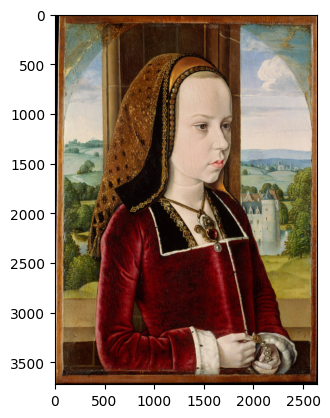

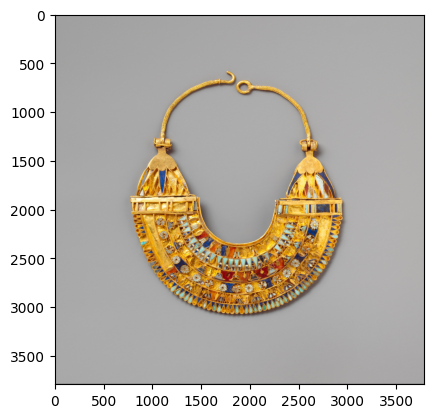

Quantizing model...
Time taken: 50.861655 seconds


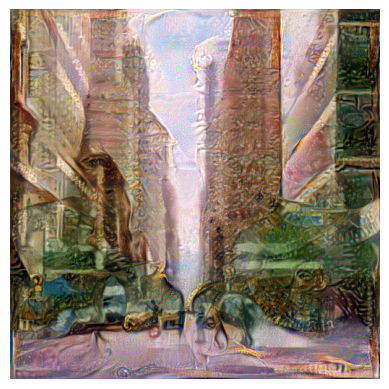

INFO:werkzeug:127.0.0.1 - - [15/Dec/2024 10:57:27] "POST /nst HTTP/1.1" 200 -


Style transfer complete! Result saved to static/output.jpg
<class 'werkzeug.datastructures.file_storage.FileStorage'>
Found 2 style images for 'rainbow'
[0.5011478073413931, 0.49885219265860686]


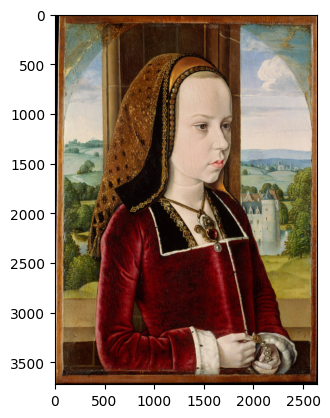

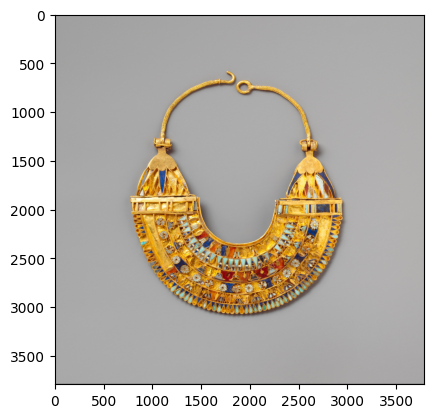

Quantizing model...
Time taken: 51.126437 seconds


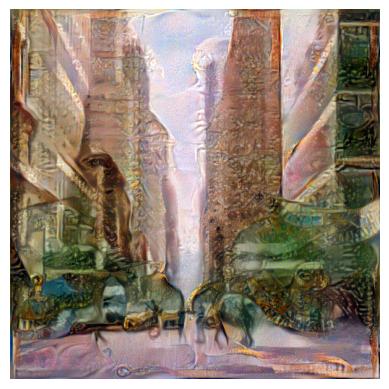

INFO:werkzeug:127.0.0.1 - - [15/Dec/2024 11:08:02] "POST /nst HTTP/1.1" 200 -


Style transfer complete! Result saved to static/output.jpg


INFO:werkzeug:127.0.0.1 - - [15/Dec/2024 11:10:24] "GET /static/output.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Dec/2024 11:10:25] "GET /favicon.ico HTTP/1.1" 404 -


<class 'werkzeug.datastructures.file_storage.FileStorage'>
Found 2 style images for 'rainbow'
[0.5011478073413931, 0.49885219265860686]


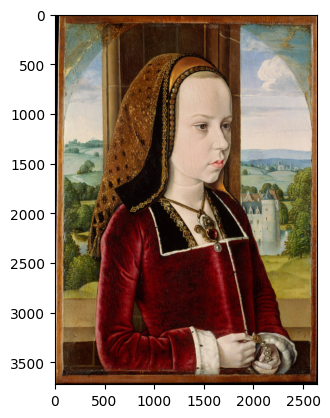

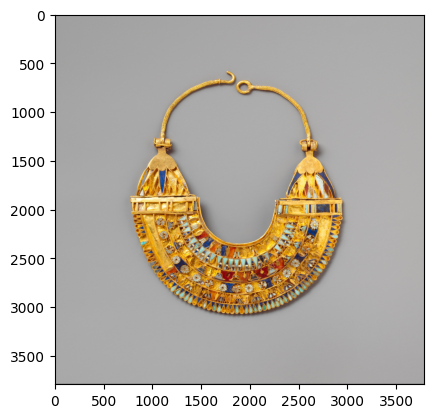

Quantizing model...
Time taken: 51.098878 seconds


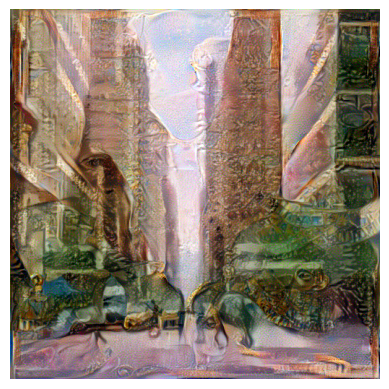

INFO:werkzeug:127.0.0.1 - - [15/Dec/2024 11:13:16] "POST /nst HTTP/1.1" 200 -


Style transfer complete! Result saved to static/output.jpg


INFO:werkzeug:127.0.0.1 - - [15/Dec/2024 11:13:16] "GET /static/output.jpg HTTP/1.1" 200 -


<class 'werkzeug.datastructures.file_storage.FileStorage'>
Found 2 style images for 'rainbow'
[0.5011478073413931, 0.49885219265860686]


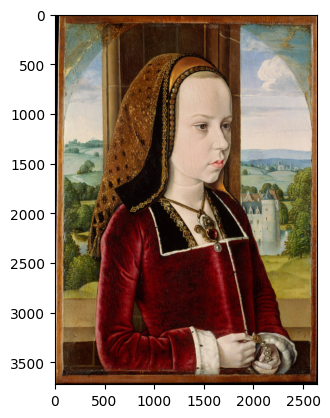

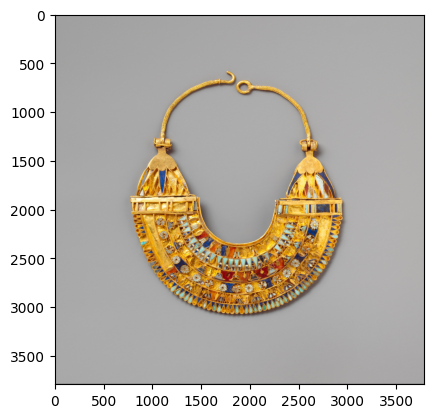

Quantizing model...
Time taken: 51.021994 seconds


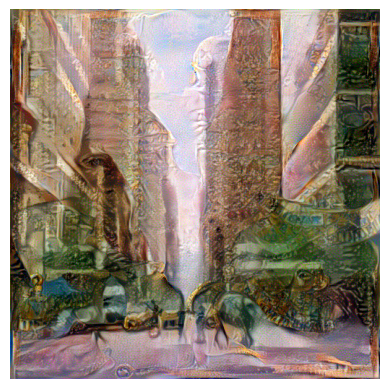

INFO:werkzeug:127.0.0.1 - - [15/Dec/2024 11:18:25] "POST /nst HTTP/1.1" 200 -


Style transfer complete! Result saved to static/output.jpg


INFO:werkzeug:127.0.0.1 - - [15/Dec/2024 11:18:26] "GET /static/output.jpg HTTP/1.1" 200 -


In [36]:
from flask import send_from_directory
import time
import requests
from flask_cors import CORS

app = Flask(__name__)
CORS(app)
#CORS(app, resources={r"/api/*": {"origins": "http://localhost:3000"}})

public_url = ngrok.connect(5000)
print(f"public_url: {public_url}")

@app.route('/')
def index():
    return jsonify({"message": "Server is running"})

@app.route('/nst', methods=['POST'])
def nst():
  try:
    # Get content and style images from the request
    content_image = request.files.get('content_image')
    print(type(content_image))
    style_prompt = request.form.get('stylePrompt')

    if not content_image or not style_prompt:
      return jsonify({"error": "Missing content image or style prompt"}), 400

    output_path = "static/output.jpg"
    result = apply_style_transfer(
        content_image_path=content_image,
        style_descriptions=[style_prompt],
        output_path=output_path,
        num_styles=2,
        do_prune_model=False,
        do_quantize_model=True)
  except Exception as e:
    app.logger.error(f"Error in /nst: {str(e)}")
    return jsonify({"error": "An error occurred while processing the request"}), 400

  return jsonify({"status": "success", "image_url": f"/{output_path}"})

@app.route('/static/<filename>')
def serve_image(filename):
  return send_from_directory('static', filename)

if __name__ == '__main__':
  os.makedirs('static', exist_ok=True)
  app.run(port=5000)


Things i want to display on web app
already: input image, text input (can have multiple text input)
 - extra: add seperate text boxes for inputs, otherwise have user input in a specific format
next:
 - for each text input: display most similar styles CLIP found and the respective style images
 - then display target image